In [7]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Problem 1

We consider the fourth order explicit Runge Kutta (RK-4) method detailed below. With this we want to estimate the region of absolute stability.

$$
\begin{align}
&k_1 = hf(x_n, y_n)\\
&k_2 = hf(x_n+\frac{1}{2}h, y_n+\frac{1}{2}k_1)\\
&k_3 = hf(x_n+\frac{1}{2}h, y_n+\frac{1}{2}k_2)\\
&k_4 = hf(x_n+h,y_n+k_3)\\
&~\\
&y_{n+1}=y_n+\frac{1}{6}(k_1+2k_2+2k_3+k_4)
\end{align}
$$

To do this we consider the test problem $y'=\lambda y$. We plug this into the RK-4 method above to get something of the form $y_{n+1}=g(z)y_n$, where $z=\lambda h$ and $g$ is a polynomial. To fully determine the region of absolute stability we would look for all $z$ such that $|g(z)|<1$. However, this is difficult so we will instead look for all solutions of $g(z)=1$. This will give us the intersections of the absolute stability region with the real and imaginary axis which we can use to estimate said region.

We complete the steps outlined above using *sympy* -- a Python package for symbolic math.

In [2]:
z, yn = sp.symbols('z yn')

k1 = z*yn
k2 = z*(yn + sp.Rational(1,2)*k1)
k3 = z*(yn + sp.Rational(1,2)*k2)
k4 = z*(yn + k3)

g = sp.simplify(yn + sp.Rational(1,6)*(k1+2*k2+2*k3+k4))/yn

sp.pprint(g)

 4    3    2        
z    z    z         
── + ── + ── + z + 1
24   6    2         


In the output above we see the resulting function $g(z)$.

In [26]:
roots = sp.solvers.solve(g-1,z)
roots = [r.evalf() for r in roots]

sp.pprint(roots)
roots = np.array([complex(r) for r in roots])

[0, -0.607353218297359 + 2.87189972821991⋅ⅈ, -0.607353218297359 - 2.8718997282
1991⋅ⅈ, -2.78529356340528]


We can see the results of $g(z)=1$ above which we will now plot for easier viewing.

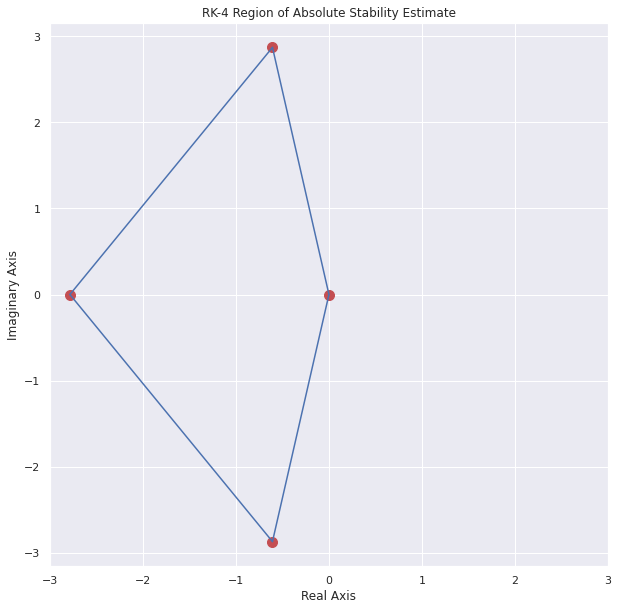

In [57]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

for r in roots:
    ax.scatter(r.real, r.imag, c='r', s=100)
    
ax.plot([roots[0].real,roots[1].real],[roots[0].imag,roots[1].imag],c='b')
ax.plot([roots[0].real,roots[2].real],[roots[0].imag,roots[2].imag],c='b')
ax.plot([roots[2].real,roots[3].real],[roots[2].imag,roots[3].imag],c='b')
ax.plot([roots[3].real,roots[1].real],[roots[3].imag,roots[1].imag],c='b')

ax.set_xlim(-3,3)

ax.set_title('RK-4 Region of Absolute Stability Estimate')
ax.set_xlabel('Real Axis')
ax.set_ylabel('Imaginary Axis');

In the plot above the intersections of the region of absolute stability are given in red. The blue lines show an estimate of the remaining boundary, although the actual boundary is likely to be more complicated than this. We also note that the region extends into the interior of the boundary shown above.

# Problem 2

We consider the following eigenvalue problem with boundary conditions:

$$ \frac{d}{dx}\Big[\frac{1}{1+x}\frac{dy}{dx}\Big]+\lambda y = 0,\quad y(0)=y(1)=0 $$

Our approach will be to use the shooting method for the IVP equivalent with $y'(0)=1$ and $\lambda\in[6.7,6.8]$. We will apply the Trapezoidal method with Repeated Richardson Extraplolation, the code for which we define below.

In [3]:
'''
convertToSys converts a higher order ODE into a system of first 
order equations.

NOTE: One can generalize this to coupled sets of equations, but this
is not currently implemented

NOTE: We assume the form is y^(k) + f(t, y^(k-1), ..., y) = F(t)

Input:
    Y -> Function of t where element i is g(t)*y^(i) for some g
    F -> RHS of system
    order -> Order of the system
Output:
    func -> RHS of vector equation y'=f(t,y)
'''
def convertToSys(Y, F, order):
    def A(t, args=()):
        A = np.diag(np.ones(order-1), 1)
        A[order-1, :] = -Y(t, *args)
        
        return A
        
    def b(t, args=()):
        b = np.zeros(order)
        b[order-1] = F(t, *args)
        
        return b
        
    return (A, b)


'''
impSolve will solve the system of equations required in a implicit
Trapezoidal ODE solver assuming a linear system of ODEs.

NOTE: We assume the form is A(t)*y + b(t) = f(t,y) = y'(t)

Input:
    A(t) -> See above
    b(t) -> See above
    y0 -> Past point
    t0 -> Past time point
    t1 -> Future time point
Output:
    y -> Next point
'''
def impSolve(A, b, y0, t0, t1, aargs=(), bargs=()):
    h = t1-t0
    
    LHS = np.eye(y0.shape[0]) - (h/2)*A(t1, aargs)
    RHS = y0 + h*((1/2)*A(t0, aargs)@y0 + b(t0, bargs) + b(t1, bargs))
    
    return np.linalg.solve(LHS, RHS)


'''
odeTrap implements the Trapezoidal rule for solving first order
initial value ODE systems.

NOTE: Assumes vector input (i.e. >=1 dimensional system)
NOTE: Assumes linear system but not necessarily homogenous

Input:
    f -> RHS of the ODE. Either f(t,y) = A(t)*y + b(t) or f such that
        y_n+1 = f(t_n, y_n) (i.e. no longer implicit)
    y0 -> Initial condition
    interval -> Solution interval, [t0, T]
    h -> Stepsize (optional)
    last -> Return solution sequence or last iterate
Output:
    y -> Computed solution on interval
'''
def odeTrap(f, y0, interval, h=1e-2, last=False, fargs=()):
    if callable(f):
        future = lambda x: f(x[0], x[1], x[2], *fargs)
    else:
        future = lambda x: impSolve(f[0], f[1], x[0], x[1], x[2], fargs)
        
    t = np.arange(interval[0], interval[1]+h, h)
    pts = len(t)
    
    y = np.zeros((y0.shape[0], pts))
    y[:,0] = y0
    
    for i in range(1, pts):
        y[:,i] = future((y[:,i-1], t[i-1], t[i]))
      
    if last:
        return y[0,-1]
    else:
        return y
    
'''
extraRich implements Repeated Richardson Extrapolation to improve
the accuracy of a given approximation method.

Input:
    F -> Approximation method
    kw -> Keyword arguments for F
    h0 -> Initial stepsize
    q -> Change in step (e.g h/q)
    p -> Form of the order (e.g. p_k = 2k)
    maxitr -> Maximum number of iterations
    tol -> Requested precision
'''
def extraRich(F, kw, h0, q, p, maxitr=20, tol=1e-6):
    A = np.zeros((maxitr, maxitr))
    
    A[0,0] = F(**kw, h=h0)
    
    for m in range(1, maxitr):
        A[m,0] = F(**kw, h=h0*(q**-m))
        
        for k in range(1, m+1):
            A[m,k] = A[m, k-1]+(A[m,k-1]-A[m-1,k-1])/(q**(p*k) - 1)
                
            if k<m and np.abs(A[m,k]-A[m-1,k])<tol:
                return A[m, k]+(A[m,k]-A[m-1,k])/(q**(p*(k+1)) - 1)
    
    print('Tolerance was not achieved.')
    
    return A[m,k]

Let us first rewrite our ODE as follows:

$$ y''-\frac{y'}{1+x} + (1+x)\lambda y = 0 $$

We can then convert this into a system of first order ODEs in the usual manner. To do this we use the functionality of the *convertToSys* function above.

In [5]:
l_low, l_high = 6.7, 6.8 #Range of lambda

#Convert ODE to first order system
Y = lambda x, lmbda: np.array([(1+x)*lmbda, -1/(1+x)])
F = lambda x: 0

system = convertToSys(Y, F, 2)

s0 = np.array([0, 1])

To find the true value of $\lambda$ such that the boundary condition is satisfied we will use the bisection method with calls to Richardson Extrapolation in the interior loop.

In [11]:
#General setup for solving
h0 = 1
kw = {'f':system, 'y0':s0, 'interval':[0,1], 'last':True}

In [12]:
#Bisection with richardson in the loop
target = 0

low = l_low
high = l_high

tol = 1e-6

for i in range(100): #100 maximum iterations
    c = (low+high)/2
    
    kw['fargs'] = (c,)
    f = extraRich(odeTrap, kw, h0, 2, 2)
    
    if np.abs(f-target) < tol:
        lmbda = c
        break
    
    if f-target > 0:
        low = c
        
    elif f-target < 0:
        high = c
        
    else:
        print('Interval does not bound solution!')
        lmbda = None
        break

In [15]:
#Now look at the whole solution with correct lambda
h = 1e-2
x = np.arange(0, 1+h, h)
sol = odeTrap(system, s0, [0,1], h=1e-2, last=False, fargs=(lmbda,))

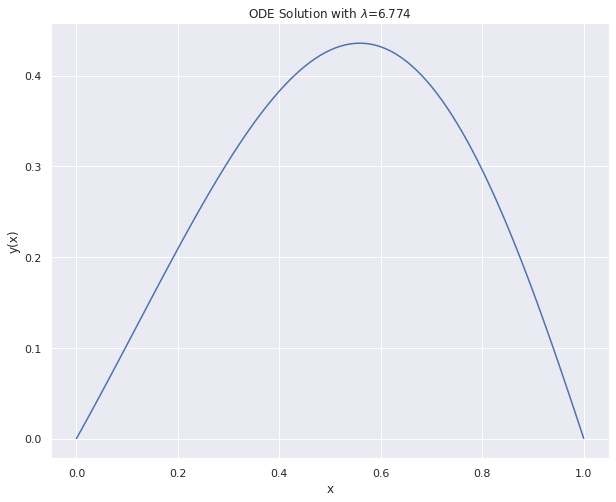

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(x, sol[0,:])
ax.set_title(fr'ODE Solution with $\lambda$={lmbda:.3f}')
ax.set_xlabel('x')
ax.set_ylabel('y(x)');

A plot of the full solution is given above where the correct $\lambda$ was found to be $\lambda\approx 6.774$.